### Determing distance using O<sub>2</sub> absorption at 760nm

March 11, 2020

---




In [0]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [0]:
# -- connect your google drive to this notebook
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# -- define the data path and read the scan
fname = "/content/drive/My Drive/vegetation/data/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing /content/drive/My Drive/vegetation/data/veg_00108.hdr...
reading /content/drive/My Drive/vegetation/data/veg_00108.raw...


In [0]:
max_ind = (np.abs(cube.waves - 790.0)).argmin()
min_ind = (np.abs(cube.waves - 740.0)).argmin()

In [0]:
waves = cube.waves[min_ind:max_ind]
print(waves)
print(waves.shape)

[740.28 741.01 741.74 742.47 743.2  743.93 744.66 745.39 746.11 746.84
 747.57 748.3  749.03 749.76 750.49 751.22 751.95 752.68 753.41 754.14
 754.87 755.6  756.33 757.06 757.79 758.52 759.26 759.99 760.72 761.45
 762.18 762.91 763.64 764.37 765.11 765.84 766.57 767.3  768.03 768.76
 769.5  770.23 770.96 771.69 772.42 773.16 773.89 774.62 775.35 776.09
 776.82 777.55 778.29 779.02 779.75 780.49 781.22 781.95 782.69 783.42
 784.15 784.89 785.62 786.35 787.09 787.82 788.56 789.29]
(68,)


In [0]:
cubeO = cube.data[min_ind:max_ind, ::4, ::4].astype(float)
print(cubeO.shape)

(68, 400, 400)


In [0]:
cubeO_2d = cubeO.transpose(1, 2, 0).reshape((cubeO.shape[1] * cubeO.shape[2]), cubeO.shape[0])
print(cubeO_2d.shape)

(160000, 68)


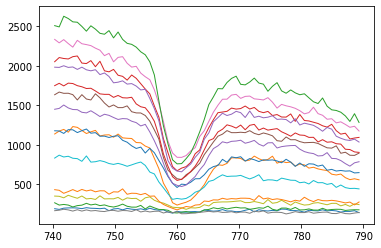

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(150)
rind = np.random.choice(range(cubeO_2d.shape[0]), 15, replace=False)
dum = plt.plot(waves, cubeO_2d[rind].T, lw=1)


In [0]:
ind1 = (np.abs(waves - 740.0)).argmin()
ind2 = (np.abs(waves - 750.0)).argmin()
ind3 = (np.abs(waves - 770.0)).argmin()
ind4 = (np.abs(waves - 790.0)).argmin()
ind_fit = np.r_[ind1:ind2, ind3:ind4]

In [0]:
waves_fit = waves[ind_fit]
print(waves_fit)
print(waves_fit.shape)

[740.28 741.01 741.74 742.47 743.2  743.93 744.66 745.39 746.11 746.84
 747.57 748.3  749.03 770.23 770.96 771.69 772.42 773.16 773.89 774.62
 775.35 776.09 776.82 777.55 778.29 779.02 779.75 780.49 781.22 781.95
 782.69 783.42 784.15 784.89 785.62 786.35 787.09 787.82 788.56]
(39,)


In [0]:
cubeO_fit = cubeO_2d[:, ind_fit]
print(cubeO_fit.shape)

(160000, 39)


In [0]:
cubeO_pseudo = np.zeros((cubeO_fit.shape[0], waves.shape[0]))

for i in range(cubeO_fit.shape[0]):
  pol = np.polyfit(waves_fit, cubeO_fit[i,:], 3)
  for j in range(waves.shape[0]):
    p = np.poly1d(pol)
    cubeO_pseudo[i, j] = p(waves[j])

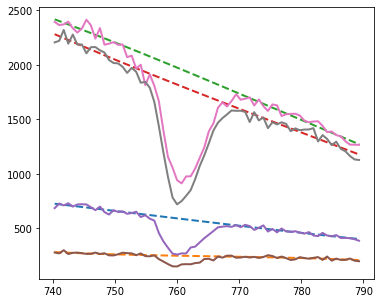

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
rind = np.random.choice(range(cubeO_2d.shape[0]), 4, replace=False)
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(waves, cubeO_pseudo[rind].T, lw=2, ls='dashed')
ax.plot(waves, cubeO_2d[rind].T, lw=2)
plt.show()

In [0]:
# normalize the absorption by subtracting the cube data from the pseudo spectrum then dividing by the pseudo spectrum

cube_abs_norm = (cubeO_pseudo - cubeO_2d) / cubeO_pseudo

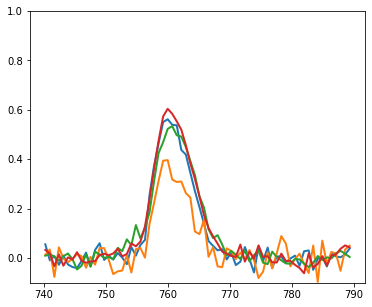

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
rind = np.random.choice(range(cubeO_2d.shape[0]), 4, replace=False)
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(waves, cube_abs_norm[rind].T, lw=2)
ax.set_ylim(-0.1,1.0)
plt.show()

In [0]:
ind_O = (np.abs(waves - 760.0)).argmin()

In [0]:
cubeO_abs = cubeO_pseudo[:,ind_O] - cubeO_2d[:,ind_O]
cubeO_abs_2d = cubeO_abs.reshape(cubeO.shape[1], cubeO.shape[2])


<function matplotlib.pyplot.show>

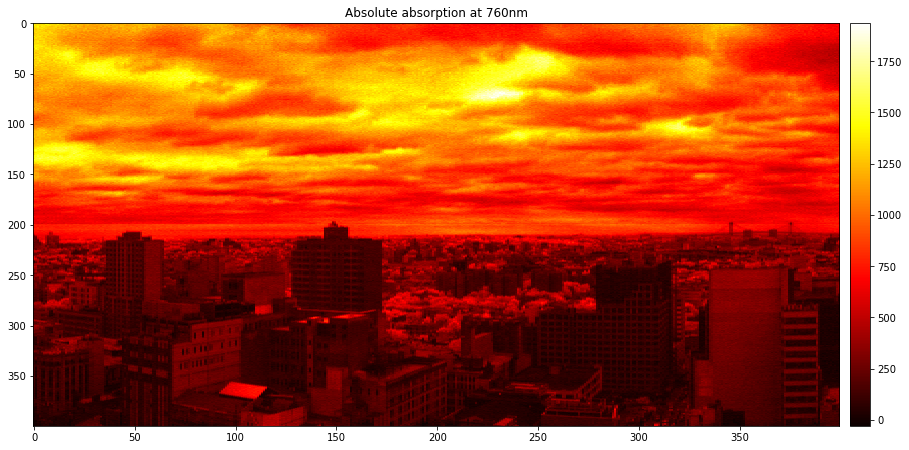

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cubeO_abs_2d, aspect=0.5, cmap='hot')
ax.set_title('Absolute absorption at 760nm')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.15, aspect=20)
plt.colorbar(im, cax=cax)
plt.show

In [0]:
cubeO_norm = cube_abs_norm[:,ind_O]
cubeO_norm_2d = cubeO_norm.reshape(cubeO.shape[1], cubeO.shape[2])

<function matplotlib.pyplot.show>

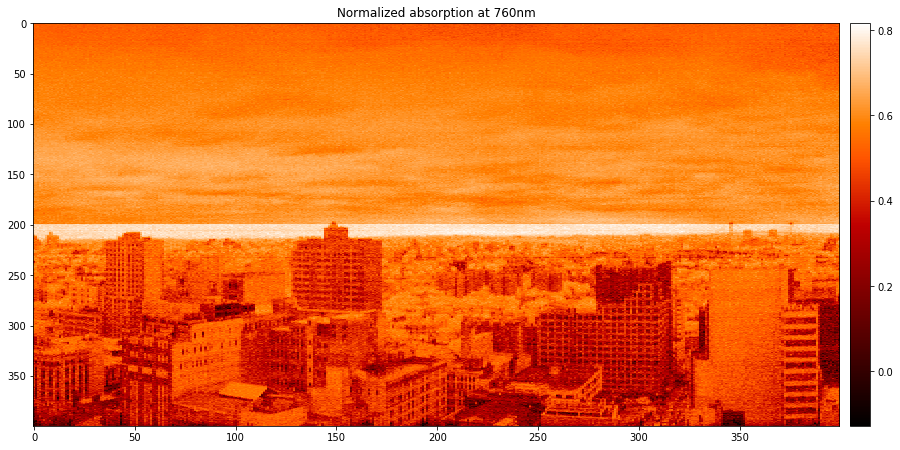

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cubeO_norm_2d, aspect=0.5, cmap='gist_heat')
ax.set_title('Normalized absorption at 760nm')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.15, aspect=20)
plt.colorbar(im, cax=cax)
plt.show

In [0]:
I_prime = cubeO_2d[:,ind_O]
I = cubeO_pseudo[:,ind_O]

In [0]:
sigma = 5e-27 #in m^2/molecule
N = 5.14e24 #in molecules/m^3 given T=300K, P=101300 N/m^2, C(O2)=0.21 mol/mol, Av = 6.023e23, R=8.31 ==> N = (C(O2) * Av * P) / (R * T)
C = (-1/(sigma * N))

L = C*np.log(I_prime / I) #in m
L_2d = L.reshape(cubeO.shape[1], cubeO.shape[2])

<function matplotlib.pyplot.show>

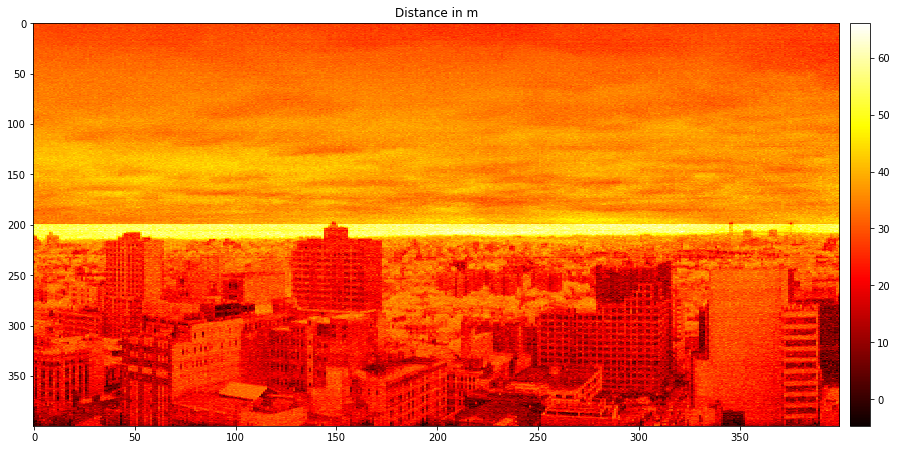

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(L_2d, aspect=0.5, cmap='hot')
ax.set_title('Distance in m')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.15, aspect=20)
plt.colorbar(im, cax=cax)
plt.show

In [0]:
print(L.min(), L.max())

-4.6632140237017685 66.13245382016417
